In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

ImportError: No module named tensorflow

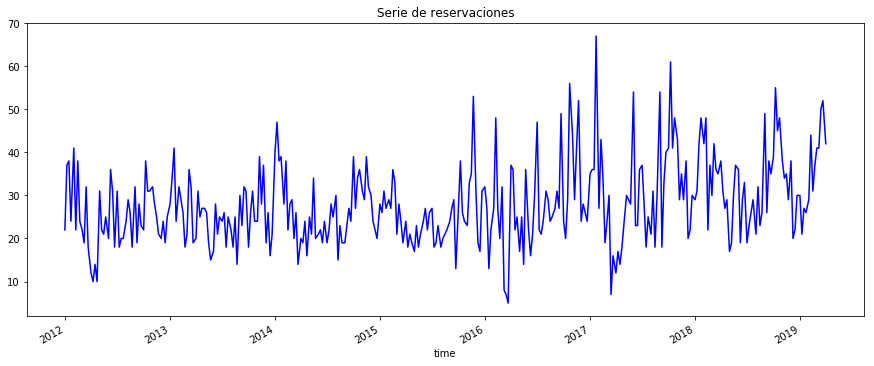

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('./data/DemandaInfo.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)
ts = data['#guests']
ts.plot(c='b', title='Serie de reservaciones')
plt.show()

In [7]:
TS = np.array(ts)
num_periods = 12
f_horizon = 1
x_data = TS[:(len(TS)-(len(TS)% num_periods))]
x_batches = x_data.reshape(-1, 12, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 12, 1)

print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

29
(29, 12, 1)
[[[22]
  [37]
  [38]
  [24]
  [41]
  [22]
  [38]
  [24]
  [22]
  [19]
  [32]
  [18]]

 [[12]
  [10]
  [14]
  [10]
  [31]
  [22]
  [21]
  [25]
  [20]
  [36]
  [31]
  [18]]]
[[[37]
  [38]
  [24]
  [41]
  [22]
  [38]
  [24]
  [22]
  [19]
  [32]
  [18]
  [12]]]
(29, 12, 1)


In [8]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 12, 1)
    testY = TS[-(num_periods):].reshape(-1, 12, 1)
    return testX,testY
X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 12, 1)
[[[30]
  [21]
  [27]
  [26]
  [29]
  [44]
  [31]
  [37]
  [41]
  [41]
  [50]
  [52]]]


In [9]:
tf.reset_default_graph()

num_periods = 12
inputs = 1
hidden = 200
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
#BasicRNNCell
#BasicLSTMCell
learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


In [10]:
epochs = 5000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 263061.5
100 	MSE: 28880.59
200 	MSE: 13264.448
300 	MSE: 10605.175
400 	MSE: 8127.984
500 	MSE: 6381.499
600 	MSE: 5720.973
700 	MSE: 5131.2188
800 	MSE: 7146.4297
900 	MSE: 5538.627
1000 	MSE: 5011.962
1100 	MSE: 4725.534
1200 	MSE: 4548.731
1300 	MSE: 9412.078
1400 	MSE: 4612.7236
1500 	MSE: 4315.3096
1600 	MSE: 4120.487
1700 	MSE: 3946.9053
1800 	MSE: 3941.5325
1900 	MSE: 3793.9658
2000 	MSE: 3735.23
2100 	MSE: 3691.9268
2200 	MSE: 3671.5828
2300 	MSE: 3631.0784
2400 	MSE: 3600.3496
2500 	MSE: 3578.4333
2600 	MSE: 3557.285
2700 	MSE: 3537.0762
2800 	MSE: 3520.5276
2900 	MSE: 3503.5315
3000 	MSE: 3496.0022
3100 	MSE: 3480.9294
3200 	MSE: 3453.115
3300 	MSE: 3445.4414
3400 	MSE: 3415.3223
3500 	MSE: 3400.6309
3600 	MSE: 3375.05
3700 	MSE: 3352.3264
3800 	MSE: 3325.5803
3900 	MSE: 3286.3306
4000 	MSE: 3238.754
4100 	MSE: 3201.377
4200 	MSE: 3164.5752
4300 	MSE: 3110.3887
4400 	MSE: 3074.3408
4500 	MSE: 3016.7463
4600 	MSE: 2999.9858
4700 	MSE: 2941.1465
4800 	MSE: 7977.293
490

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100, np.mean(np.abs((y_true - y_pred) / y_true))

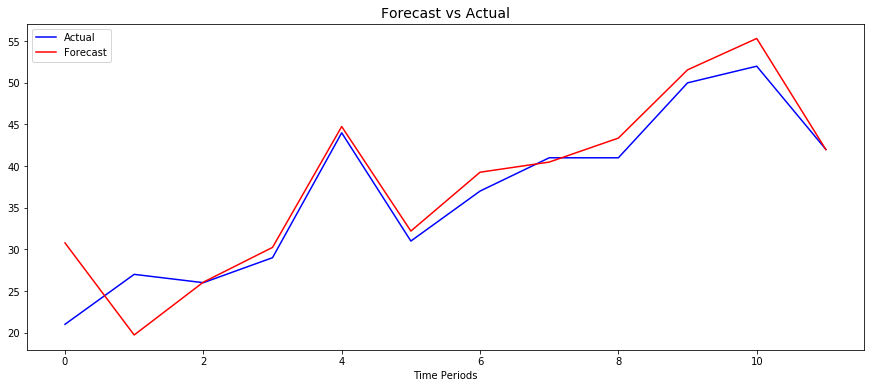

TEST
[[[21]
  [27]
  [26]
  [29]
  [44]
  [31]
  [37]
  [41]
  [41]
  [50]
  [52]
  [42]]]
PRED
[[[30.773487]
  [19.719166]
  [26.06374 ]
  [30.236153]
  [44.75144 ]
  [32.19738 ]
  [39.2654  ]
  [40.4843  ]
  [43.365597]
  [51.563206]
  [55.331142]
  [41.983604]]]


In [12]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'b', markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), 'r', markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()
print('TEST')
print(Y_test)
print('PRED')
print(y_pred)

In [13]:
MAPE, MAD = mean_absolute_percentage_error(Y_test,y_pred)
print("MAPE : {}".format(MAPE))
print("MAD : {}".format(MAD))

MAPE : 8.8588580284431
MAD : 0.08858858028443099
